In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter

import os
from os import path
from glob import glob
import sys
import csv
sys.path.insert(0, path.abspath('./'))

from src import workdir, parse_model_parameter_file
from src.emulator_BAND import EmulatorBAND
#from src.emulator import Emulator

import re

parent="../actual/"


In [3]:
def rms_abs_prediction_err(emu_pred,vali_true):
    rms_abs_pred_err = np.zeros(emu_pred.shape[1])
    for obsIdx in range(emu_pred.shape[1]):
        quantity = np.zeros(emu_pred.shape[1])
        for testpoint in range(emu_pred.shape[0]):
            quantity[obsIdx] += ((emu_pred[testpoint,obsIdx] - vali_true[testpoint,obsIdx]) / vali_true[testpoint,obsIdx])**2.
        rms_abs_pred_err[obsIdx] = np.sqrt(quantity[obsIdx] / emu_pred.shape[0])
    return rms_abs_pred_err

def how_honest_is_GP(emu_pred,emu_pred_err,vali_true):
    rms_quantity = np.zeros(emu_pred.shape[1])
    for obsIdx in range(emu_pred.shape[1]):
        quantity = np.zeros(emu_pred.shape[1])
        for testpoint in range(emu_pred.shape[0]):
            quantity[obsIdx] += ((emu_pred[testpoint,obsIdx] - vali_true[testpoint,obsIdx]) / emu_pred_err[testpoint,obsIdx])**2.
        rms_quantity[obsIdx] = np.sqrt(quantity[obsIdx] / emu_pred.shape[0])
    return rms_quantity

def train_multiple_emulators(training_set, model_par, number_test_points, logFlag, parameterTrafoPCAFlag):
    emu1 = EmulatorBAND(training_set, model_par, method='PCGP', logTrafo=logFlag, parameterTrafoPCA=parameterTrafoPCAFlag)
    emu2 = EmulatorBAND(training_set, model_par, method='PCSK', logTrafo=logFlag, parameterTrafoPCA=parameterTrafoPCAFlag)
    #emu3 = Emulator(training_set, model_par, npc = 4, logTrafo=logFlag, parameterTrafoPCA=parameterTrafoPCAFlag)

    output_emu1 = emu1.testEmulatorErrors(number_test_points=number_test_points)
    emu_pred_1 = output_emu1[0]
    emu_pred_err_1 = output_emu1[1]
    vali_data_1 = output_emu1[2]
    vali_data_err_1 = output_emu1[3]

    output_emu2 = emu2.testEmulatorErrors(number_test_points=number_test_points)
    emu_pred_2 = output_emu2[0]
    emu_pred_err_2 = output_emu2[1]
    vali_data_2 = output_emu2[2]
    vali_data_err_2 = output_emu2[3]

    # output_emu3 = emu3.testEmulatorErrors(nTestPoints=number_test_points)
    # emu_pred_3 = output_emu3[0]
    # emu_pred_err_3 = output_emu3[1]
    # vali_data_3 = output_emu3[2]
    # vali_data_err_3 = output_emu3[3]

    nObs = vali_data_1.shape[1]  # Assuming all datasets have the same number of observables

    rms_abs_pred_err1 = rms_abs_prediction_err(emu_pred_1,vali_data_1)
    rms_abs_pred_err2 = rms_abs_prediction_err(emu_pred_2,vali_data_2)
    #rms_abs_pred_err3 = rms_abs_prediction_err(emu_pred_3,vali_data_3)
    honesty_1 = how_honest_is_GP(emu_pred_1,emu_pred_err_1,vali_data_1)
    honesty_2 = how_honest_is_GP(emu_pred_2,emu_pred_err_2,vali_data_2)
    #honesty_3 = how_honest_is_GP(emu_pred_3,emu_pred_err_3,vali_data_3)

    return (rms_abs_pred_err1,rms_abs_pred_err2), (honesty_1,honesty_2)


In [4]:
def read_emulator_file_errors(filename):
    data = []
    with open(filename, 'r') as file:
        for line in file:
            data.append(float(line.strip()))
    return data

def read_multiple_emulator_errors_files(number_test_points_list,foldername,filename):
    data_list1 = []
    data_list2 = []

    for i in number_test_points_list:
        filename1 = f"{foldername}/{filename}_{i}_pred_err_obs_1.dat"
        data1 = read_emulator_file_errors(filename1)
        data_list1.append(data1)

        filename2 = f"{foldername}/{filename}_{i}_pred_err_obs_2.dat"
        data2 = read_emulator_file_errors(filename2)
        data_list2.append(data2)

        # filename3 = f"./{foldername}/{filename}_{i}_pred_err_obs_3.dat"
        # data3 = read_emulator_file_errors(filename3)
        # data_list3.append(data3)
    
    data_list4 = []
    data_list5 = []

    for i in number_test_points_list:
        filename4 = f"./{foldername}/{filename}_{i}_GP_honesty_obs_1.dat"
        data4 = read_emulator_file_errors(filename4)
        data_list4.append(data4)

        filename5 = f"./{foldername}/{filename}_{i}_GP_honesty_obs_2.dat"
        data5 = read_emulator_file_errors(filename5)
        data_list5.append(data5)

    return (data_list1,data_list2), (data_list4,data_list5)


In [5]:


def convert_to_notation(filename):
    # Remove 'exp_', '../latent_pickled/', and '.pkl'
    filename = re.sub(r'(exp_|\.pkl|../latent_pickled/)', '', filename)
    filename = re.sub(r'star_v(.*)_pT', r'starv\1pt', filename)
    filename = re.sub(r'star_v', 'starv', filename)
    filename = re.sub(r'phenix_pT_v', 'phenixptv', filename)
    
    filename = re.sub(r'eta_spectra', 'etas', filename)
    filename = re.sub(r'y_spectra', 'ys', filename)
    filename = re.sub(r'pT_spectra', 'pTs', filename)
    filename = re.sub(r'phobos_v2_spectra', 'v2eta', filename)
    # Mapping for observables
    observables = {
        'etas': r'$\frac{dN}{d\eta}$',
        'ys': r'$\frac{dN}{dy}$',
        'pTs': r'$\frac{dN}{d(p_T)}$',
        'dNdy': r'$\left.\frac{dN}{dy}\right|_{y=0}$',
        'meanpT': r'$\langle p_T \rangle |_{y=0}$',
        'starv2': r'$\left.v_2\right.\{2\}$',
        'starv3': r'$\left.v_3\right.\{2\}$',
        'phenixptv2': r'$v_2(p_T)$',
        'phenixptv3': r'$v_3(p_T)$',
        'starv2pt': r'$v_2(p_T)$',
        'starv3pt': r'$v_3(p_T)$',
        'v2eta': r'$v_2(\eta)$'
    }
    particles= {
        'kminus': r'K^-',
        'kplus': r'K^+',
        'p': 'p',
        'pbar': r'\bar{p}',
        'piminus': r'\pi^-',
        'piplus': r'\pi^+'
    }   
    
    # Identify the particle and the observable
    #print(filename)
    parts = filename.split('_')
    #print(parts)
    particle = ''
    observable = ''
    integrated = False
    for part in parts:
        if part in observables:
            observable = observables[part]
        elif part in particles:
            particle = particles[part]
        elif part == 'integrated':
            integrated = True
    # Add particle notation for y_spectra
    if integrated and particle == 'p':
        pass
    elif integrated and particle != '':
        observable=''
    elif ('ys' in filename or 'pTs' in filename or integrated) and not 'star' in filename:
        observable = observable[:-1] + f'({particle})$'

   
    #print(observable)
    #print("------")
    # Return the formatted string
    return observable

print(convert_to_notation('star_v2_pT_spectra.pkl'))

$v_2(p_T)$


In [15]:
import pickle

def extract_info_from_filename(filename):
    # Remove the path and extension
    parts = filename.split('_')
    
    # Extract energy, centrality, and observable
    energy = parts[1]
    centrality = parts[2]
    observable = '_'.join(parts[3:])


    
    return energy, centrality, observable

import re

filename_prefix_list = []
#training_set= ['../latent_pickled/exp_19.6_05_eta_spectra.pkl', '../latent_pickled/exp_200_05_y_spectra_piminus.pkl', '../latent_pickled/exp_19.6_05_integrated_dNdy_kminus.pkl', '../latent_pickled/exp_19.6_05_integrated_dNdy_kplus.pkl', '../latent_pickled/exp_19.6_05_integrated_dNdy_p.pkl', '../latent_pickled/exp_19.6_05_integrated_dNdy_pbar.pkl', '../latent_pickled/exp_19.6_05_integrated_dNdy_piminus.pkl', '../latent_pickled/exp_19.6_05_integrated_dNdy_piplus.pkl', '../latent_pickled/exp_19.6_05_integrated_meanpT_kminus.pkl', '../latent_pickled/exp_19.6_05_integrated_meanpT_kplus.pkl', '../latent_pickled/exp_19.6_05_integrated_meanpT_p.pkl', '../latent_pickled/exp_19.6_05_integrated_meanpT_pbar.pkl', '../latent_pickled/exp_19.6_05_integrated_meanpT_piminus.pkl', '../latent_pickled/exp_19.6_05_integrated_meanpT_piplus.pkl', '../latent_pickled/exp_19.6_05_integrated_star_v2.pkl', '../latent_pickled/exp_19.6_05_integrated_star_v3.pkl', '../latent_pickled/exp_200_05_y_spectra_piplus.pkl', '../latent_pickled/exp_19.6_05_pT_spectra_kminus.pkl', '../latent_pickled/exp_200_1525_eta_spectra.pkl', '../latent_pickled/exp_19.6_05_pT_spectra_kplus.pkl', '../latent_pickled/exp_200_1525_phobos_v2_spectra.pkl', '../latent_pickled/exp_19.6_05_pT_spectra_p.pkl', '../latent_pickled/exp_200_2030_integrated_dNdy_kminus.pkl', '../latent_pickled/exp_200_2030_integrated_dNdy_kplus.pkl', '../latent_pickled/exp_200_2030_integrated_dNdy_p.pkl', '../latent_pickled/exp_200_2030_integrated_dNdy_pbar.pkl', '../latent_pickled/exp_200_2030_integrated_dNdy_piminus.pkl', '../latent_pickled/exp_200_2030_integrated_dNdy_piplus.pkl', '../latent_pickled/exp_200_2030_integrated_meanpT_kminus.pkl', '../latent_pickled/exp_200_2030_integrated_meanpT_kplus.pkl', '../latent_pickled/exp_200_2030_integrated_meanpT_p.pkl', '../latent_pickled/exp_200_2030_integrated_meanpT_pbar.pkl', '../latent_pickled/exp_200_2030_integrated_meanpT_piminus.pkl', '../latent_pickled/exp_200_2030_integrated_meanpT_piplus.pkl', '../latent_pickled/exp_200_2030_integrated_star_v2.pkl', '../latent_pickled/exp_200_2030_integrated_star_v3.pkl', '../latent_pickled/exp_19.6_05_pT_spectra_pbar.pkl', '../latent_pickled/exp_200_2030_phenix_pT_v2_spectra.pkl', '../latent_pickled/exp_19.6_05_pT_spectra_piminus.pkl', '../latent_pickled/exp_200_2030_phenix_pT_v3_spectra.pkl', '../latent_pickled/exp_19.6_05_pT_spectra_piplus.pkl', '../latent_pickled/exp_200_2030_pT_spectra_kminus.pkl', '../latent_pickled/exp_19.6_1525_eta_spectra.pkl', '../latent_pickled/exp_200_2030_pT_spectra_kplus.pkl', '../latent_pickled/exp_200_2030_pT_spectra_p.pkl', '../latent_pickled/exp_19.6_2030_integrated_dNdy_kminus.pkl', '../latent_pickled/exp_19.6_2030_integrated_dNdy_kplus.pkl', '../latent_pickled/exp_19.6_2030_integrated_dNdy_p.pkl', '../latent_pickled/exp_19.6_2030_integrated_dNdy_pbar.pkl', '../latent_pickled/exp_19.6_2030_integrated_dNdy_piminus.pkl', '../latent_pickled/exp_19.6_2030_integrated_dNdy_piplus.pkl', '../latent_pickled/exp_19.6_2030_integrated_meanpT_kminus.pkl', '../latent_pickled/exp_19.6_2030_integrated_meanpT_kplus.pkl', '../latent_pickled/exp_19.6_2030_integrated_meanpT_p.pkl', '../latent_pickled/exp_19.6_2030_integrated_meanpT_pbar.pkl', '../latent_pickled/exp_19.6_2030_integrated_meanpT_piminus.pkl', '../latent_pickled/exp_19.6_2030_integrated_meanpT_piplus.pkl', '../latent_pickled/exp_19.6_2030_integrated_star_v2.pkl', '../latent_pickled/exp_19.6_2030_integrated_star_v3.pkl', '../latent_pickled/exp_200_2030_pT_spectra_pbar.pkl', '../latent_pickled/exp_19.6_2030_pT_spectra_kminus.pkl', '../latent_pickled/exp_200_2030_pT_spectra_piminus.pkl', '../latent_pickled/exp_19.6_2030_pT_spectra_kplus.pkl', '../latent_pickled/exp_200_2030_pT_spectra_piplus.pkl', '../latent_pickled/exp_19.6_2030_pT_spectra_p.pkl', '../latent_pickled/exp_7.7_05_integrated_dNdy_kminus.pkl', '../latent_pickled/exp_7.7_05_integrated_dNdy_kplus.pkl', '../latent_pickled/exp_7.7_05_integrated_dNdy_p.pkl', '../latent_pickled/exp_7.7_05_integrated_dNdy_pbar.pkl', '../latent_pickled/exp_7.7_05_integrated_dNdy_piminus.pkl', '../latent_pickled/exp_7.7_05_integrated_dNdy_piplus.pkl', '../latent_pickled/exp_7.7_05_integrated_meanpT_kminus.pkl', '../latent_pickled/exp_7.7_05_integrated_meanpT_kplus.pkl', '../latent_pickled/exp_7.7_05_integrated_meanpT_p.pkl', '../latent_pickled/exp_7.7_05_integrated_meanpT_pbar.pkl', '../latent_pickled/exp_7.7_05_integrated_meanpT_piminus.pkl', '../latent_pickled/exp_7.7_05_integrated_meanpT_piplus.pkl', '../latent_pickled/exp_7.7_05_integrated_star_v2.pkl', '../latent_pickled/exp_7.7_05_integrated_star_v3.pkl', '../latent_pickled/exp_19.6_2030_pT_spectra_pbar.pkl', '../latent_pickled/exp_7.7_05_pT_spectra_kminus.pkl', '../latent_pickled/exp_19.6_2030_pT_spectra_piminus.pkl', '../latent_pickled/exp_7.7_05_pT_spectra_kplus.pkl', '../latent_pickled/exp_19.6_2030_pT_spectra_piplus.pkl', '../latent_pickled/exp_7.7_05_pT_spectra_p.pkl', '../latent_pickled/exp_19.6_2030_star_v2_pT_spectra.pkl', '../latent_pickled/exp_7.7_05_pT_spectra_pbar.pkl', '../latent_pickled/exp_200_05_eta_spectra.pkl', '../latent_pickled/exp_7.7_05_pT_spectra_piminus.pkl', '../latent_pickled/exp_200_05_integrated_dNdy_kminus.pkl', '../latent_pickled/exp_200_05_integrated_dNdy_kplus.pkl', '../latent_pickled/exp_200_05_integrated_dNdy_p.pkl', '../latent_pickled/exp_200_05_integrated_dNdy_pbar.pkl', '../latent_pickled/exp_200_05_integrated_dNdy_piminus.pkl', '../latent_pickled/exp_200_05_integrated_dNdy_piplus.pkl', '../latent_pickled/exp_200_05_integrated_meanpT_kminus.pkl', '../latent_pickled/exp_200_05_integrated_meanpT_kplus.pkl', '../latent_pickled/exp_200_05_integrated_meanpT_p.pkl', '../latent_pickled/exp_200_05_integrated_meanpT_pbar.pkl', '../latent_pickled/exp_200_05_integrated_meanpT_piminus.pkl', '../latent_pickled/exp_200_05_integrated_meanpT_piplus.pkl', '../latent_pickled/exp_200_05_integrated_star_v2.pkl', '../latent_pickled/exp_200_05_integrated_star_v3.pkl', '../latent_pickled/exp_7.7_05_pT_spectra_piplus.pkl', '../latent_pickled/exp_200_05_pT_spectra_kminus.pkl', '../latent_pickled/exp_7.7_2030_integrated_dNdy_kminus.pkl', '../latent_pickled/exp_7.7_2030_integrated_dNdy_kplus.pkl', '../latent_pickled/exp_7.7_2030_integrated_dNdy_p.pkl', '../latent_pickled/exp_7.7_2030_integrated_dNdy_pbar.pkl', '../latent_pickled/exp_7.7_2030_integrated_dNdy_piminus.pkl', '../latent_pickled/exp_7.7_2030_integrated_dNdy_piplus.pkl', '../latent_pickled/exp_7.7_2030_integrated_meanpT_kminus.pkl', '../latent_pickled/exp_7.7_2030_integrated_meanpT_kplus.pkl', '../latent_pickled/exp_7.7_2030_integrated_meanpT_p.pkl', '../latent_pickled/exp_7.7_2030_integrated_meanpT_pbar.pkl', '../latent_pickled/exp_7.7_2030_integrated_meanpT_piminus.pkl', '../latent_pickled/exp_7.7_2030_integrated_meanpT_piplus.pkl', '../latent_pickled/exp_7.7_2030_integrated_star_v2.pkl', '../latent_pickled/exp_7.7_2030_integrated_star_v3.pkl', '../latent_pickled/exp_200_05_pT_spectra_kplus.pkl', '../latent_pickled/exp_7.7_2030_pT_spectra_kminus.pkl', '../latent_pickled/exp_200_05_pT_spectra_p.pkl', '../latent_pickled/exp_7.7_2030_pT_spectra_kplus.pkl', '../latent_pickled/exp_200_05_pT_spectra_pbar.pkl', '../latent_pickled/exp_7.7_2030_pT_spectra_p.pkl', '../latent_pickled/exp_200_05_pT_spectra_piminus.pkl', '../latent_pickled/exp_7.7_2030_pT_spectra_pbar.pkl', '../latent_pickled/exp_200_05_pT_spectra_piplus.pkl', '../latent_pickled/exp_7.7_2030_pT_spectra_piminus.pkl', '../latent_pickled/exp_200_05_y_spectra_kminus.pkl', '../latent_pickled/exp_7.7_2030_pT_spectra_piplus.pkl', '../latent_pickled/exp_200_05_y_spectra_kplus.pkl', '../latent_pickled/exp_7.7_2030_star_v2_pT_spectra.pkl']

from collections import defaultdict

# Initialize the data structure
data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

foldername = parent+'validation_LOG/'

err1_list = []
err2_list = []
hon1_list = []
hon2_list = []

err, hon = read_multiple_emulator_errors_files([15], foldername, "full_base_cut_3")
with open(parent+"latent_train/full_base_cut_3.pkl", "rb") as fp:
            dataDict = pickle.load(fp)[0] #we only take first event
for i, name in enumerate(dataDict["name"]):
        #filename_prefix_list.append(name)
        #print(name)
        energy, centrality, observable = extract_info_from_filename(name)
        start=dataDict["lim"][i]
        #print(start)
        end=dataDict["lim"][i+1]
        data[energy][centrality]["name"].append(observable)
        data[energy][centrality]["err1"].append(err[0][0][start:end])
        #print(err1_list[-1][-1])
        data[energy][centrality]["err2"].append(err[1][0][start:end])
        data[energy][centrality]["hon1"].append(hon[0][0][start:end])
        data[energy][centrality]["hon2"].append(hon[1][0][start:end])
        

[INFO][_mathtext] Substituting symbol E from STIXNonUnicode
[INFO][_mathtext] Substituting symbol E from STIXNonUnicode
[INFO][_mathtext] Substituting symbol H from STIXNonUnicode
[INFO][_mathtext] Substituting symbol H from STIXNonUnicode
[INFO][_mathtext] Substituting symbol E from STIXNonUnicode


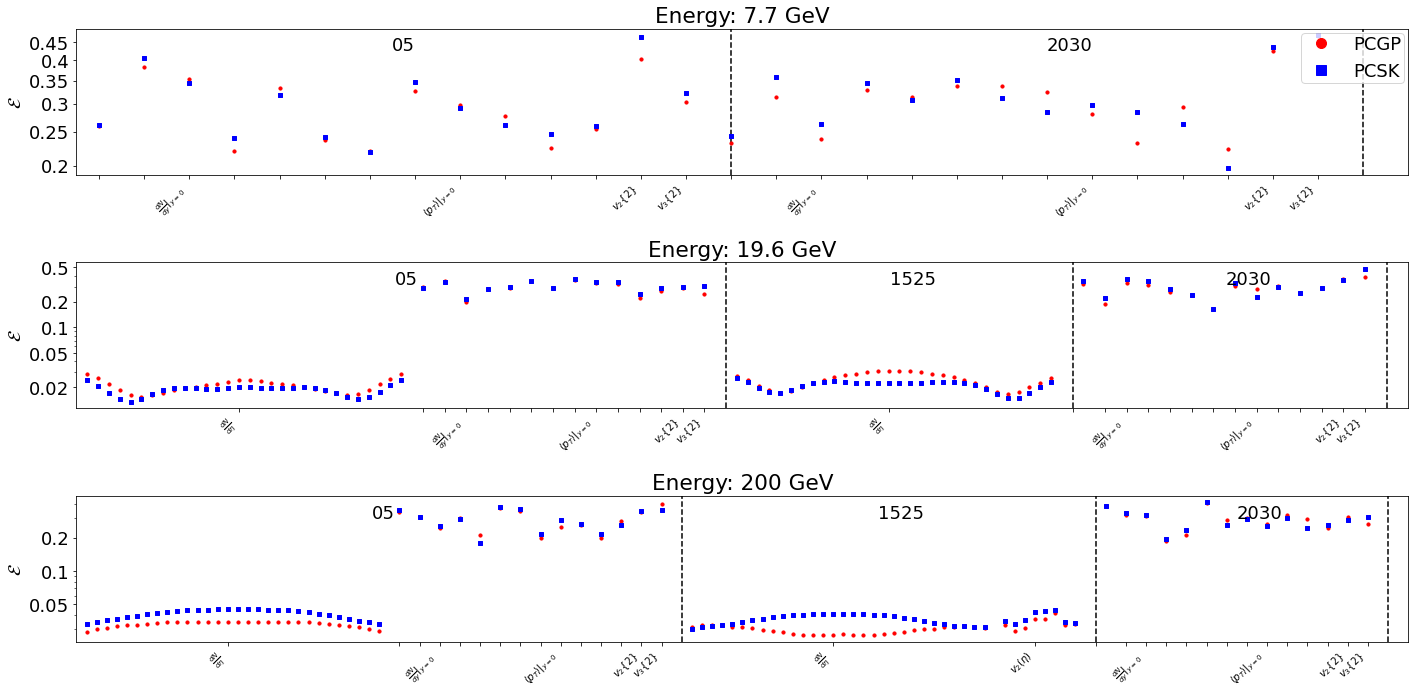

[INFO][_mathtext] Substituting symbol H from STIXNonUnicode


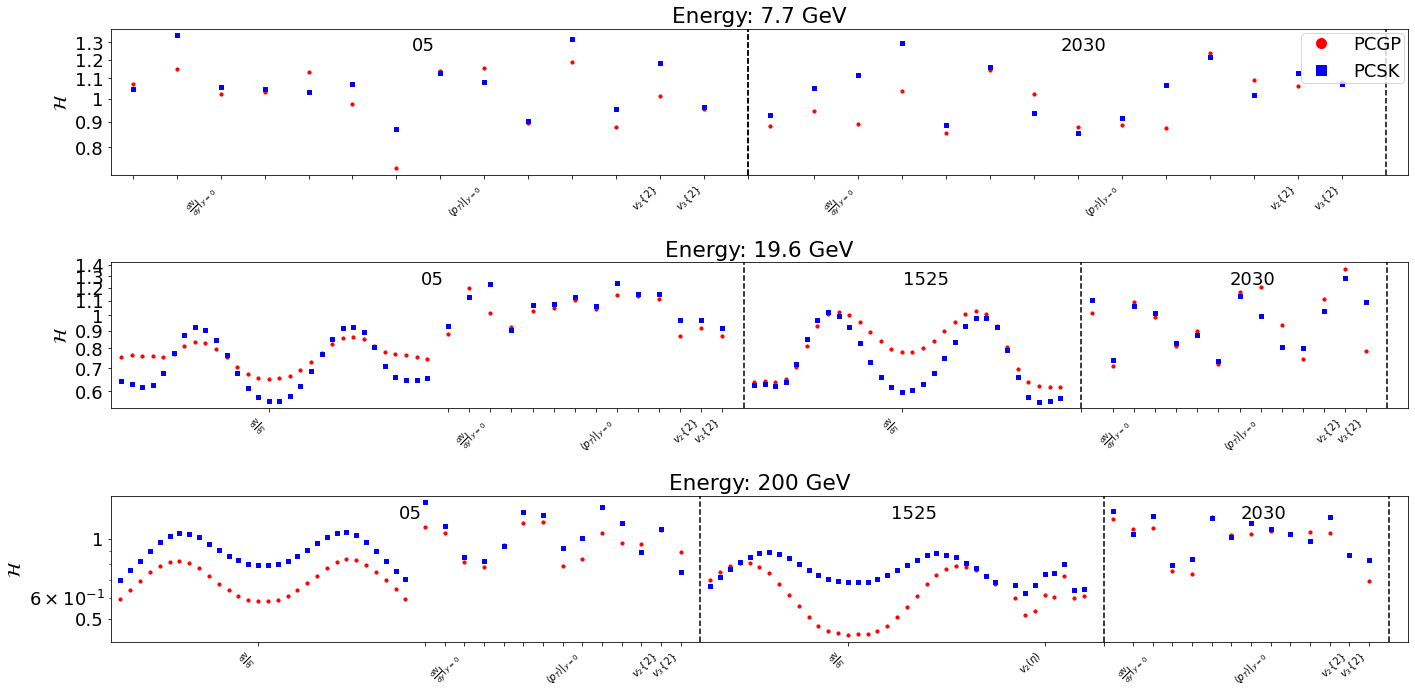

In [16]:
colors = ['r', 'b', 'g', 'magenta', 'teal', 'orange', 'purple', 'grey', 'seagreen']

fig, axs = plt.subplots(3, 1, figsize=(20, 10))
plt.rc('font', size=18)

energies = ['7.7', '19.6', '200']
centralities = ['05', '1525', '2030']
id_max=[-1]
for i, energy in enumerate(energies):
    axs[i].set_title(f'Energy: {energy} GeV')
   
    dataset_boundaries = [0]
    cent_boundaries = [0]
    idx_observable = 0
    midpoint=[]
    cent=[]
    for centrality in centralities:
        
        if centrality in data[energy]:
            cent_boundaries.append(idx_observable)
            for dataset in range(len(data[energy][centrality]["name"])):
                #idx = filename_prefix_list.index(f'exp_{energy}_{centrality}_{data[energy][centrality][dataset]}')
                # if(energy=='200'):
                #     print(data[energy][centrality][dataset])
                #     print(len(err1_list[dataset][-1]))
                #     print("-----")
                #print(data[energy][centrality]["name"][dataset])
                for obs in range(len(data[energy][centrality]["err1"][dataset])):
                    axs[i].scatter(idx_observable, np.abs(data[energy][centrality]["err1"][dataset][obs]), color=colors[0], marker='o', s=10)
                    axs[i].scatter(idx_observable, np.abs(data[energy][centrality]["err2"][dataset][obs]), color=colors[1], marker='s', s=10)
                    idx_observable += 1
                    #print(obs)
                    #print(dataset)
                    #print(data[energy][centrality][dataset])
                    
                idx_observable+=1
                dataset_boundaries.append(idx_observable)
            
            axs[i].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))
            if not (energy=='7.7' and centrality=='05'):
                idx_observable+=1
            #idx_observable+=2
            if not (energy=='7.7' and centrality=='1525'):
                midpoint.append((idx_observable + cent_boundaries[-1]) / 2)
                cent.append(centrality)
            
    id_max.append(idx_observable)
    for k,mid in enumerate(midpoint):
        axs[i].text(mid/idx_observable, 0.82, cent[k], rotation=0, verticalalignment='bottom', horizontalalignment='center',transform=axs[i].transAxes)
        
    
    average_indices = [(start + end) // 2  - 1 for start, end in zip(dataset_boundaries[:-1], dataset_boundaries[1:])]
    #print(average_indices)
    #print(average_indices)
    axs[i].set_xticks(average_indices)
    labels = [convert_to_notation(f'{obs}') for centrality in centralities for obs in data[energy][centrality]["name"]]
    #print(labels)
    #print(labels)
    #print(labels)
    axs[i].set_xticklabels(labels, rotation=45, ha='right', fontsize=10)

    #for boundary, cent in zip(dataset_boundaries[:-1], centralities):
        

legend_elements = [
    plt.Line2D([0], [0], marker='o', color=colors[0], markersize=10, label='PCGP', linestyle='None'),
    plt.Line2D([0], [0], marker='s', color=colors[1], markersize=10, label='PCSK', linestyle='None'),
]

axs[0].legend(handles=legend_elements, loc='upper right', borderpad=0.12, borderaxespad=0.25)

for i,ax in enumerate(axs):
    ax.set_xlim([-1, id_max[i+1] + 1])
    ax.set_ylabel(r"$\mathcal{E}$")
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
    ax.yaxis.set_major_locator(ticker.LogLocator(subs=[1.0, 2.0, 5.0]))  # Ensure at least two labels

plt.tight_layout()
plt.savefig("err_full_training_set_LHCpoints_noPCA_LOG.pdf")

# # honesty plot
fig, axs = plt.subplots(3, 1, figsize=(20, 10))
plt.rc('font', size=18)

energies = ['7.7', '19.6', '200']
centralities = ['05', '1525', '2030']

for i, energy in enumerate(energies):
    axs[i].set_title(f'Energy: {energy} GeV')
   
    dataset_boundaries = [0]
    cent_boundaries = [0]
    idx_observable = 0
    midpoint=[]
    cent=[]
    for centrality in centralities:
        
        if centrality in data[energy]:
            cent_boundaries.append(idx_observable)
            for dataset in range(len(data[energy][centrality]["name"])):
                #idx = filename_prefix_list.index(f'exp_{energy}_{centrality}_{data[energy][centrality][dataset]}')
                # if(energy=='200'):
                #     print(data[energy][centrality][dataset])
                #     print(len(err1_list[dataset][-1]))
                #     print("-----")
                #print(data[energy][centrality]["name"][dataset])
                for obs in range(len(data[energy][centrality]["err1"][dataset])):
                    axs[i].scatter(idx_observable, np.abs(data[energy][centrality]["hon1"][dataset][obs]), color=colors[0], marker='o', s=10)
                    axs[i].scatter(idx_observable, np.abs(data[energy][centrality]["hon2"][dataset][obs]), color=colors[1], marker='s', s=10)
                    idx_observable += 1
                    #print(obs)
                    #print(dataset)
                    #print(data[energy][centrality][dataset])
                    
                idx_observable+=1
                dataset_boundaries.append(idx_observable)
            
            axs[i].axvline(x=idx_observable, color='k', linestyle='--', zorder=(-10))
            if not (energy=='7.7' and centrality=='05'):
                idx_observable+=1
            #idx_observable+=2
            if not (energy=='7.7' and centrality=='1525'):
                midpoint.append((idx_observable + cent_boundaries[-1]) / 2)
                cent.append(centrality)
            
    id_max.append(idx_observable)
    for k,mid in enumerate(midpoint):
        axs[i].text(mid/idx_observable, 0.82, cent[k], rotation=0, verticalalignment='bottom', horizontalalignment='center',transform=axs[i].transAxes)
    
    average_indices = [(start + end) // 2  - 1 for start, end in zip(dataset_boundaries[:-1], dataset_boundaries[1:])]
    #print(average_indices)
    #print(average_indices)
    axs[i].set_xticks(average_indices)
    labels = [convert_to_notation(f'{obs}') for centrality in centralities for obs in data[energy][centrality]["name"]]
    #print(labels)
    #print(labels)
    #print(labels)
    axs[i].set_xticklabels(labels, rotation=45, ha='right', fontsize=10)

    #for boundary, cent in zip(dataset_boundaries[:-1], centralities):
        

legend_elements = [
    plt.Line2D([0], [0], marker='o', color=colors[0], markersize=10, label='PCGP', linestyle='None'),
    plt.Line2D([0], [0], marker='s', color=colors[1], markersize=10, label='PCSK', linestyle='None'),
]

axs[0].legend(handles=legend_elements, loc='upper right', borderpad=0.12, borderaxespad=0.25)

for i,ax in enumerate(axs):
    ax.set_xlim([-1, id_max[i+1] + 1])
    ax.set_ylabel(r"$\mathcal{H}$")
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
    ax.yaxis.set_major_locator(ticker.LogLocator(subs=[1.0, 2.0, 5.0]))  # Ensure at least two labels

plt.tight_layout()
plt.savefig("hon_full_training_set_LHCpoints_noPCA_LOG.pdf")